<a href="https://colab.research.google.com/github/lmhoang47/CS2225.CH1501/blob/master/class_work/ch2002016_VuCongTanTai/lab-04/AgeDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load images

Load libraries:

In [ ]:
!rm -rf models && mkdir models
!rm -rf images && mkdir images
!pip install gdown

In [2]:
import numpy as np
import argparse
import cv2
import os
from skimage import io
from google.colab.patches import cv2_imshow

Download Face & Age detection model:

In [ ]:
import gdown

url = "https://drive.google.com/uc?id=13B2uRi7TNjGy8GPQw4I-dhpJ38fJ2sXP"
filename = "models/deploy.prototxt"
gdown.download(url, filename, quiet=False)

url = "https://drive.google.com/uc?id=13Pamn7aaKJLbMoTgP4QS_Wu9NRvBH7b3"
filename = "models/res10_300x300_ssd_iter_140000.caffemodel"
gdown.download(url, filename, quiet=False)

url = "https://drive.google.com/uc?id=1HMwuBHVsaqu43-RF7PELhs72qoW-z--l"
filename = "models/age_deploy.prototxt"
gdown.download(url, filename, quiet=False)

url = "https://drive.google.com/uc?id=1lWF8ggx04OHd-9tPm5b72i58lt7efKno"
filename = "models/age_net.caffemodel"
gdown.download(url, filename, quiet=False)


# Note, to use gdown, we change the link from the google drive
# From: https://drive.google.com/file/d/13B2uRi7TNjGy8GPQw4I-dhpJ38fJ2sXP/view?usp=sharing
# To: https://drive.google.com/uc?id=13B2uRi7TNjGy8GPQw4I-dhpJ38fJ2sXP
# Drive folder: https://drive.google.com/drive/u/3/folders/1Xu2fn6SD-odJzchjMbDg4LWegv68iar5
# Account: taivct.15@grad.uit.edu.vn

Load Face & Age detection model:

In [ ]:
# Uncomment to integrate GDrive to Colab
# from google.colab import drive
# drive.mount('/content/gdrive')
# 4/4wGCM-N707GXX5p-WPl84LOQiTdssub9F35Uvvkye3b5bow7hT_r9Rk

AGE_BUCKETS = ["(0-2)", "(4-6)", "(8-12)", "(15-20)", "(25-32)", "(38-43)", "(48-53)", "(60-100)"]

# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = "models/deploy.prototxt"
weightsPath = "models/res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load our serialized age detector model from disk
print("[INFO] loading age detector model...")
prototxtPath = "models/age_deploy.prototxt"
weightsPath = "models/age_net.caffemodel"
ageNet = cv2.dnn.readNet(prototxtPath, weightsPath)

Upload an image to predict: 


Saving 1.jpg to 1.jpg


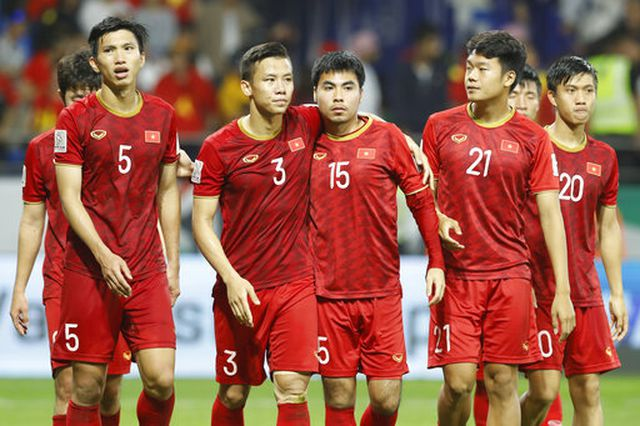

In [7]:
import os
from google.colab import files
from IPython.display import Image

# Upload images
print("Upload an image to predict: ")
uploaded = files.upload()
imageName = list(uploaded.keys())[0] # only process one image

# Move file
os.rename(imageName, "images/" + imageName)
imageName = "images/" + imageName

display(Image(imageName))

Run detector

[INFO] computing face detections...
[INFO] (25-32): 83.39%
[INFO] (25-32): 89.04%
[INFO] (25-32): 40.85%
[INFO] (25-32): 66.34%
[INFO] (25-32): 95.41%


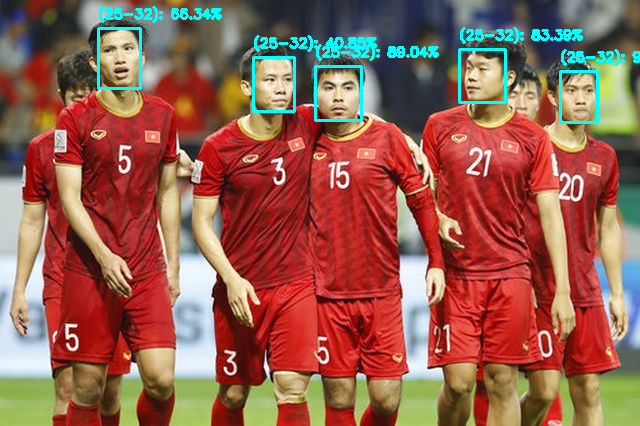

In [9]:
DEFAULT_CONFIDENCE = 0.7

image = cv2.imread(imageName)
(h, w) = image.shape[:2]
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))

# pass the blob through the network and obtain the face detections
print("[INFO] computing face detections...")
faceNet.setInput(blob)
detections = faceNet.forward()

# loop over the detections
for i in range(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with the
	# prediction
	confidence = detections[0, 0, i, 2]

	# filter out weak detections by ensuring the confidence is
	# greater than the minimum confidence
	if confidence > DEFAULT_CONFIDENCE:
		# compute the (x, y)-coordinates of the bounding box for the
		# object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")
  
		# extract the ROI of the face and then construct a blob from
		# *only* the face ROI
		face = image[startY:endY, startX:endX]
		faceBlob = cv2.dnn.blobFromImage(face, 1.0, (227, 227), (78.4263377603, 87.7689143744, 114.895847746), swapRB=False)
  
    # make predictions on the age and find the age bucket with
		# the largest corresponding probability
		ageNet.setInput(faceBlob)
		preds = ageNet.forward()
		i = preds[0].argmax()
		age = AGE_BUCKETS[i]
		ageConfidence = preds[0][i]

		# display the predicted age to our terminal
		text = "{}: {:.2f}%".format(age, ageConfidence * 100)
		print("[INFO] {}".format(text))
  
		# draw the bounding box of the face along with the associated
		# predicted age
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.rectangle(image, (startX, startY), (endX, endY), (255, 255, 0), 2)
		cv2.putText(image, text, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 255, 0), 2)

# display the output image
cv2_imshow(image)